In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd

In [48]:
import datetime as dt

In [49]:
#Reflect Tables into SQLAlchemy ORM-------------------------------------------------------------

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session

In [51]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model using 'automap_base()'
Base = automap_base()
# Use the base class to reflect the tables
Base.prepare(engine, reflect=True)

In [53]:
# print (view) all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# Assign references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [55]:
# Create a session (link) from Python to the DB
session = Session(engine)

In [56]:
#Exploratory Climate Analysis--------------------------------------------------------------------

In [57]:
#find max_date
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [74]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

In [75]:
#set index
precipitation_df.set_index('date', inplace=True)
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


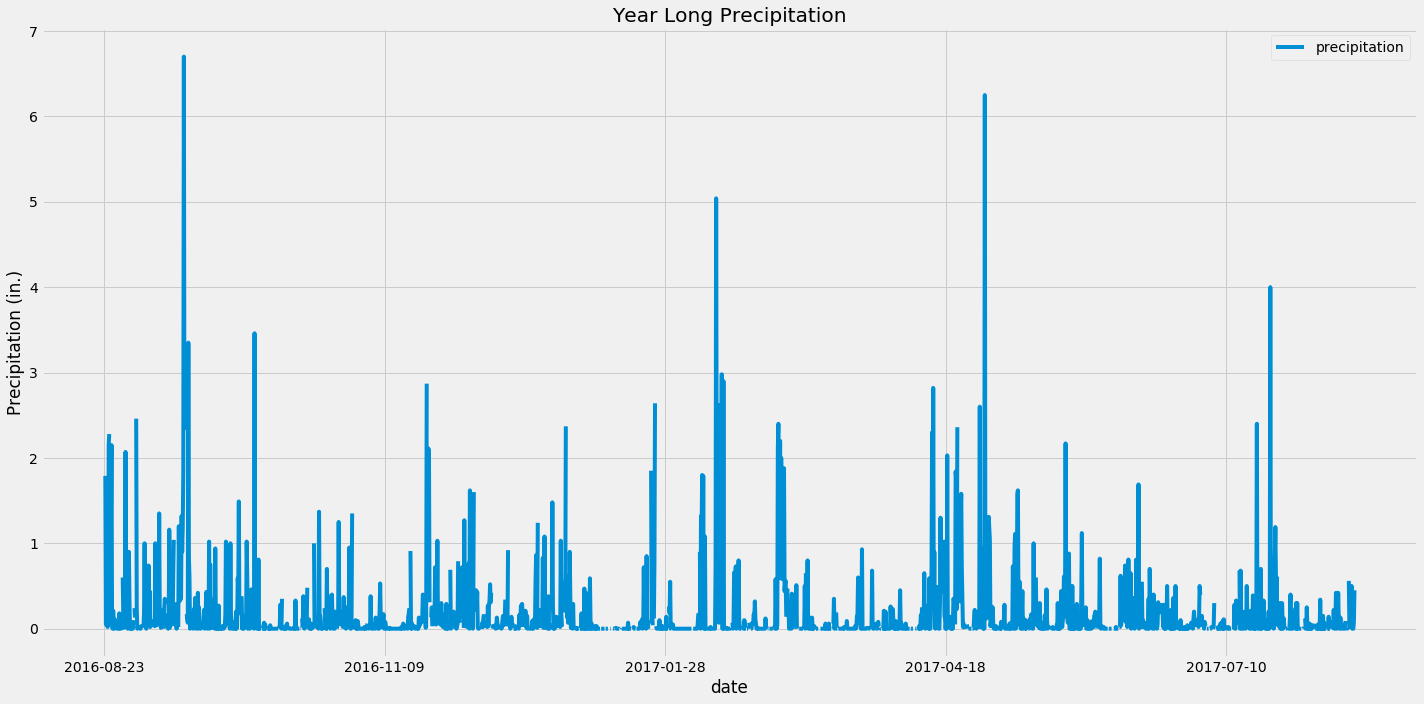

In [85]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True)

ax.set_xlabel = ('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/precipitation.png")

plt.tight_layout()
plt.show()

In [17]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
        .group_by(Measurement.station)
        .order_by(func.count(Measurement.station).desc())
        .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, 
# Calculate the  lowest, Highest and Average temperatures recorded.
most_active_station = 'USC00519281'
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temp

[(54.0, 85.0, 71.66378066378067)]

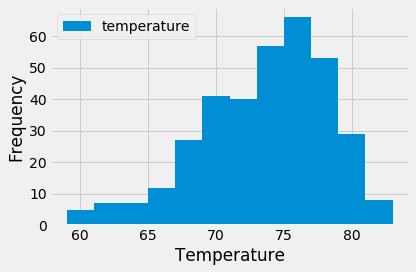

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as dataframe
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

plt.savefig("Images/station-histogram.png")

plt.tight_layout()
plt.show()

In [21]:
# Bonus Challenge Assignment-----------------------------------------------

In [ ]:
#Temperature Analysis (optional)-------------------------------------------

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-04-18','2017-07-10')
trip_temps

[(58.0, 75.94871794871794, 87.0)]

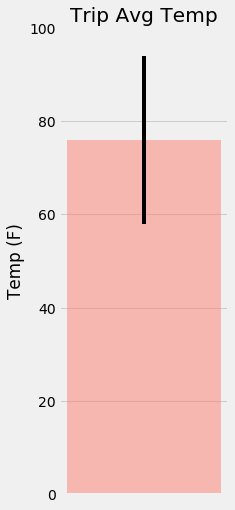

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][1]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][0]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(2.7,8))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'salmon', alpha=.5)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.savefig("Images/temperature.png")

plt.show()